In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import json

from tqdm.notebook import tqdm, trange

from figures_style import initialise_figures
initialise_figures()

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Loading the data

In [2]:
DATA_FOLDER_PATH = 'dmi_data'
DATA_PARQUET_PATH = 'dmi_data/dmi.parquet'

if not os.path.exists(DATA_PARQUET_PATH):
    data_all = dict()

    for root, _, files in os.walk('dmi_data'):
        if root == 'dmi_data/2020' or root == 'dmi_data/2021':
            for f in tqdm(files, desc=root[-4:]):
                with open(os.path.join(root, f), 'r') as ifh:
                    for line in ifh:
                        data = json.loads(line)

                        if data['properties']['parameterId'] in ['precip_past10min', 'temp_dry', 'wind_speed']:
                            data_all[data['id']] = {
                                'Longitude':  data['geometry']['coordinates'][0],
                                'Latitude': data['geometry']['coordinates'][1],
                                'Property': data['properties']['parameterId'],
                                'Observed': data['properties']['observed'],
                                'Station ID': data['properties']['stationId'],
                                'Value': data['properties']['value']
                            }

    print('Building DataFrame...')
    df = pd.DataFrame.from_dict(data_all, orient='index')

    df['Property'] = df['Property'].astype('category')
    df['Observed'] = pd.to_datetime(df['Observed'])
    
    print('Saving to Parquet...')
    df.to_parquet(DATA_PARQUET_PATH)
    
    del data_all, df

df = pd.read_parquet(DATA_PARQUET_PATH)
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 23434392 entries, 02fc19e8-269e-02be-c090-68a45ce60f5a to ffe0c282-ea50-6091-94ae-2ae3c203c8cc
Data columns (total 6 columns):
 #   Column      Non-Null Count     Dtype              
---  ------      --------------     -----              
 0   Longitude   23434392 non-null  float64            
 1   Latitude    23434392 non-null  float64            
 2   Property    23434392 non-null  category           
 3   Observed    23434392 non-null  datetime64[ns, UTC]
 4   Station ID  23434392 non-null  object             
 5   Value       23434392 non-null  float64            
dtypes: category(1), datetime64[ns, UTC](1), float64(3), object(1)
memory usage: 1.1+ GB


In [3]:
stations_df = pd.DataFrame(columns=['Country', 'Station Name'])

with open('dmi_data/dmi_stations.json') as ifh:
    stations = json.load(ifh)
    
for station in stations['features']:
    stations_df.loc[station['properties']['stationId']] = (
        station['properties']['country'],
        station['properties']['name']
    )
    
stations_df['Country'] = stations_df['Country'].astype('category')

df = df.merge(stations_df, left_on='Station ID', right_index=True, how='left')
df.head()

,Longitude,Latitude,Property,Observed,Station ID,Value,Country,Station Name
02fc19e8-269e-02be-c090-68a45ce60f5a,9.5067,56.7558,temp_dry,2021-07-14 23:50:00+00:00,06065,17.3,DNK,Års Syd
041e120a-f27b-28a6-b024-7b0afef36efd,12.2400,54.9600,precip_past10min,2021-07-14 23:50:00+00:00,05986,0.0,DNK,Ny Borre
0462dd3b-ce21-3d5e-743a-c1b963ec045b,11.3515,54.6573,precip_past10min,2021-07-14 23:50:00+00:00,05970,0.0,DNK,Rødbyhavn
04670cc5-1e9e-42d0-e145-798c4c05fab9,9.6684,55.2555,precip_past10min,2021-07-14 23:50:00+00:00,05395,0.0,DNK,Hajstrup
047afa3d-775a-2075-2cae-e7f7ac2b98b5,10.9939,54.8205,wind_speed,2021-07-14 23:50:00+00:00,06138,3.1,DNK,Langø


## Pre-processing data

In [4]:
dmi = df[(df['Country'] == 'DNK') & (df['Property'] != 'precip_past10min')]\
        .groupby([pd.Grouper(key='Observed', freq='D', closed='left', label='left'), 'Property', 'Station ID'])['Value'].agg([
    'min',
    'mean',
    'max'
]).dropna().reset_index().groupby(['Observed', 'Property'])[['min', 'mean', 'max']].mean()

dmi.loc[pd.IndexSlice[:, 'precip_past10min'], 'mean'] = df[(df['Country'] == 'DNK') & (df['Property'] == 'precip_past10min') & (df['Value'] >= 0)]\
  .groupby([pd.Grouper(key='Observed', freq='D', closed='left', label='left'), 'Station ID'], as_index=False)['Value'].sum()\
  .groupby('Observed')['Value'].agg('mean').values

dmi = dmi.rename(index={'precip_past10min': 'Precipitation', 'temp_dry': 'Temperature', 'wind_speed': 'Wind Speed'},
                 columns={'min': 'Average Minimum', 'mean': 'Average', 'max': 'Average maximum'})

dmi.index = dmi.index.set_levels(dmi.index.levels[0].tz_localize(None), level=0)

dmi.head(20)

Average Minimum   Average  Average maximum
Observed   Property                                                 
2020-01-01 Precipitation              NaN  0.023404              NaN
           Temperature           2.329091  4.638280         5.841818
           Wind Speed            3.861538  6.878333         9.650000
2020-01-02 Precipitation              NaN  0.090426              NaN
           Temperature           2.789091  3.795035         4.967273
           Wind Speed            5.605769  8.089140        10.969231
2020-01-03 Precipitation              NaN  2.566316              NaN
           Temperature           3.575000  5.690617         7.308929
           Wind Speed            3.392453  7.728790        11.822642
2020-01-04 Precipitation              NaN  3.672632              NaN
           Temperature           1.178571  4.403302         6.269643
           Wind Speed            2.694340  8.690654        13.894340
2020-01-05 Precipitation              NaN  0.587368              NaN
           Temperature           0.562500  4.061653         6.128571
           Wind Speed            1.847170  5.224265         8.150943
2020-01-06 Precipitation              NaN  0.487368              NaN
           Temperature           4.825455  6.025057         6.845455
           Wind Speed            4.003846  6.217494         8.478846
2020-01-07 Precipitation              NaN  0.784211              NaN
           Temperature           4.203636  5.867678         7.356364

In [5]:
dmi.to_parquet('dmi_data/dmi_daily_agg.parquet')

## Short exploration

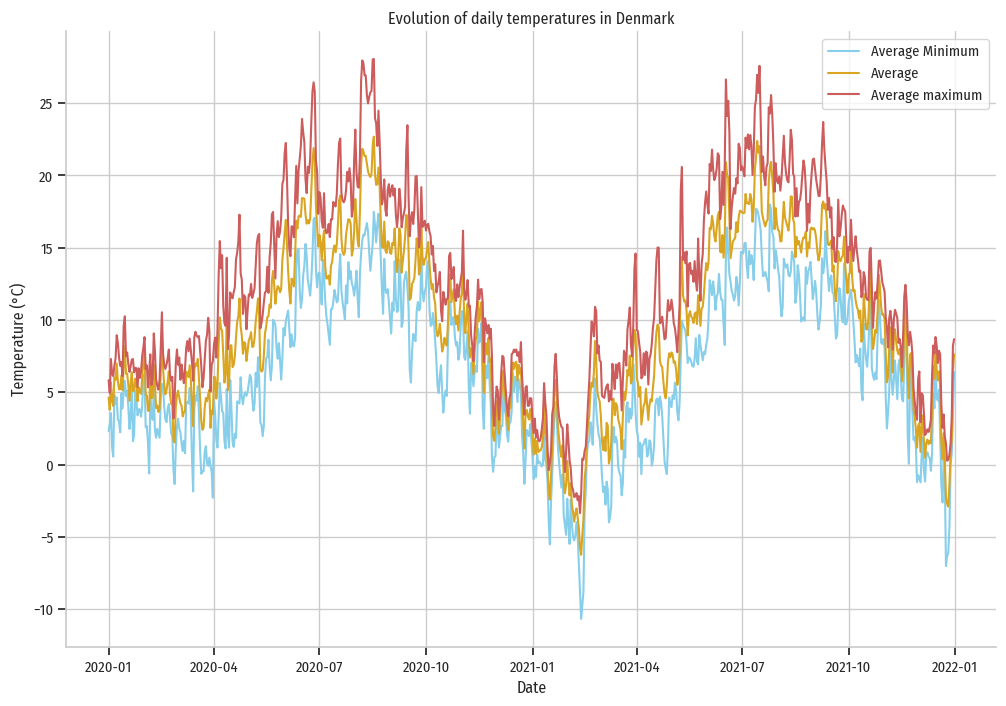

In [6]:
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=dmi.loc(axis=0)[:, 'Temperature'].reset_index(), x='Observed', y='Average Minimum', label='Average Minimum', color='skyblue')
sns.lineplot(data=dmi.loc(axis=0)[:, 'Temperature'].reset_index(), x='Observed', y='Average', label='Average', color='goldenrod')
sns.lineplot(data=dmi.loc(axis=0)[:, 'Temperature'].reset_index(), x='Observed', y='Average maximum', label='Average maximum', color='indianred')

ax.set(title='Evolution of daily temperatures in Denmark', xlabel='Date', ylabel='Temperature (°C)')

plt.legend()
plt.show()

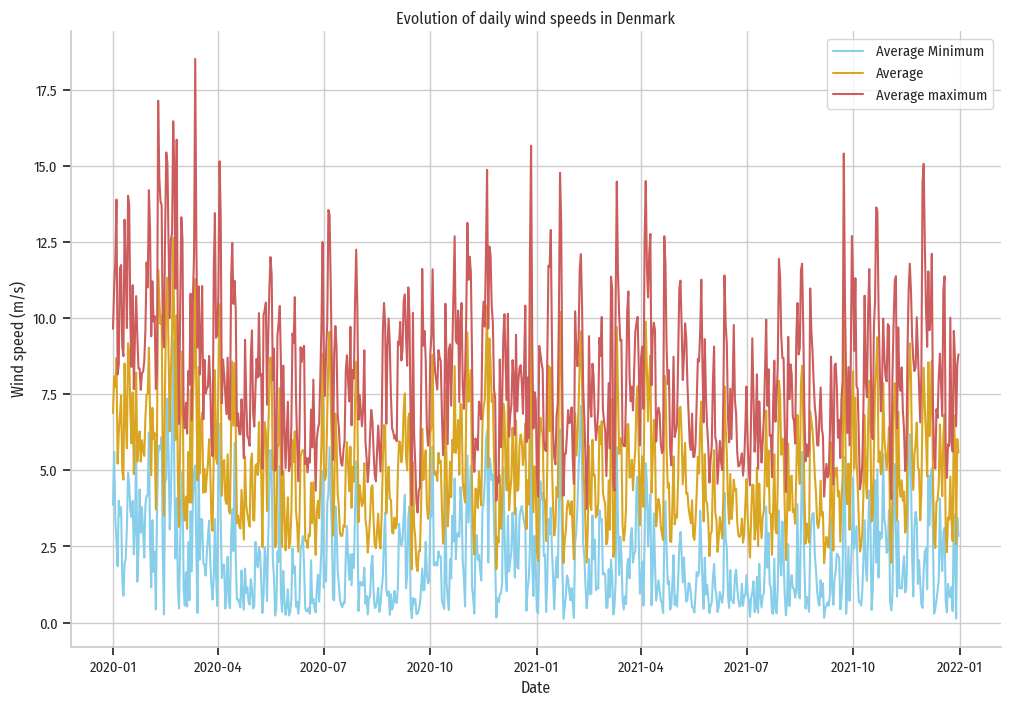

In [7]:
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=dmi.loc(axis=0)[:, 'Wind Speed'].reset_index(), x='Observed', y='Average Minimum', label='Average Minimum', color='skyblue')
sns.lineplot(data=dmi.loc(axis=0)[:, 'Wind Speed'].reset_index(), x='Observed', y='Average', label='Average', color='goldenrod')
sns.lineplot(data=dmi.loc(axis=0)[:, 'Wind Speed'].reset_index(), x='Observed', y='Average maximum', label='Average maximum', color='indianred')

ax.set(title='Evolution of daily wind speeds in Denmark', xlabel='Date', ylabel='Wind speed (m/s)')

plt.legend()
plt.show()

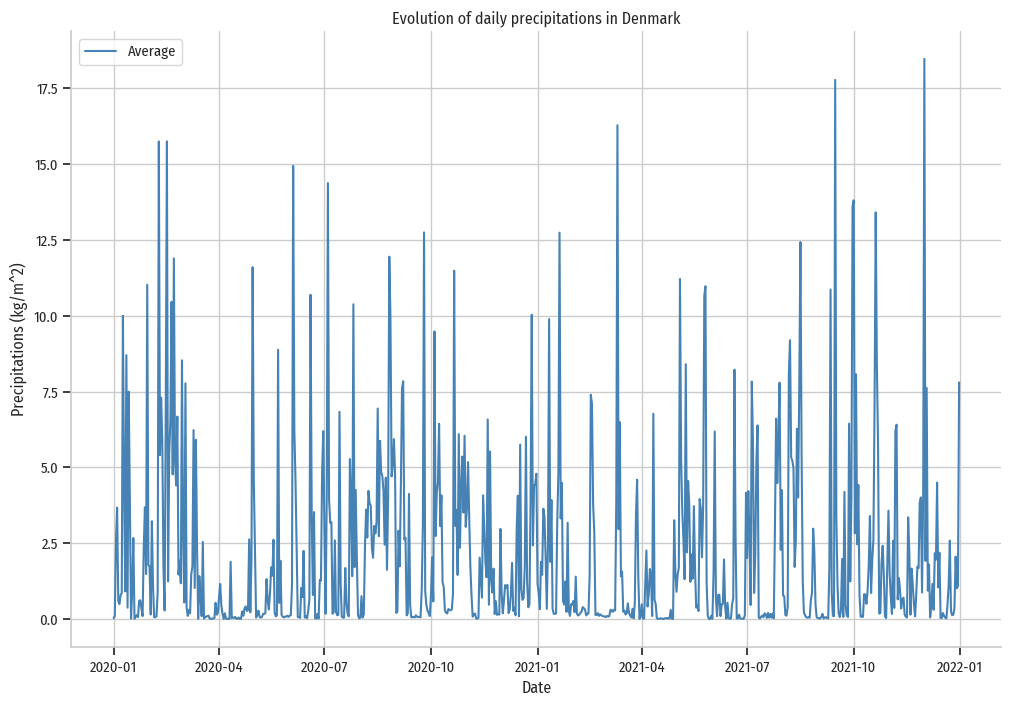

In [8]:
_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=dmi.loc(axis=0)[:, 'Precipitation'].reset_index(), x='Observed', y='Average', label='Average', color='steelblue')

ax.set(title='Evolution of daily precipitations in Denmark', xlabel='Date', ylabel='Precipitations (kg/m^2)')

plt.legend()
plt.show()